# Example application to RiverLab Monticello site
## stream chemistry dataset

This is an example of the clustering-PCA-IT workflow applied to one case study, stream chemistry variables observed at Monticello Riverlab site in Illinois. This case and all others are available as .py files in this folder.  The code "DataPrep_RiverMonticello.py" is first used to obtain a single csv file with all response and driver variables with any gaps and bad data removed.

To make this code run quickly - we resample the data to 6-hourly, while 30min time step is used in main results.  We also only use Monticello RL data up to July of 2022, as published in (Wang et al, 2024, https://doi.org/10.1016/j.scitotenv.2023.167379)

## Initial setup
- import functions
- load csv file with data as columns
- pick variable names as response and driver variables, corresponding short names for labels
- set IT metric parameters

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import pandas as pd
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import cluster_funcs as cf  #THIS function has all the codes for clustering and IT analyses

sns_list = sns.color_palette('deep').as_hex()
sns_list.insert(0, '#ffffff')  # Insert white at zero position
sns_cmap = ListedColormap(sns_list)
cm = sns_cmap

#%%  Load data, pick columns 

#set number of clusters
nc=6


data_folder='DATA/Processed/'
datafile_name = 'ProcessedData_RiverMonticello_UPToJuly2022Only.csv'

#Load data
df = pd.read_csv(data_folder+datafile_name)
df['Date']=pd.to_datetime(df['Date'])
df= df.set_index(df['Date']).resample('6H').mean()

df = df.dropna()

colnames_responses = ['Calcium','Magnesium','Potassium','Sodium','Chlorides','Nitrates','Sulfates']
colnames_drivers = ['LogQ','LogQ10','D5TE_VWC_100cm_Avg','D5TE_VWC_5cm_Avg','Temperature','Turbidity']

labels_responses=['Ca','Mg','K','Na','Cl','NO3','SO4']
labels_drivers = ['LQ','LQ10','VWCd','VWCs','Tw','Turb']

seed = 3696299933  #  Keep a seed for plotting

#IT metrics options (KDE method for pdf estimation is a built-in option)
nbins=25
nTests = 0
critval = 3
Imin = 0.1

nfeatures=len(colnames_responses)
ntars = len(colnames_drivers)

colnames_all = colnames_responses+colnames_drivers
labels_all = labels_responses + labels_drivers

/var/folders/b_/95gp2bdd5q1dcfmm84py5bvc0000gq/T/ipykernel_54540/3442552548.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date']=pd.to_datetime(df['Date'])


In [2]:
df

,Date,Calcium,Magnesium,Potassium,Sodium,Chlorides,Nitrates,Sulfates,CalciumLoad_g,MagnesiumLoad_g,...,Precip_14D,D5TE_VWC_5cm_Avg,D5TE_VWC_100cm_Avg,Temp_anomaly_14D,Turbidity,GWE,Temperature,LE_li_wpl,LEsmooth,LogQ10
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-30 06:00:00,2021-08-30 11:30:00.000000000,2.070000,1.420000,0.060000,0.650000,0.840000,0.150000,0.380000,5.754600,3.947600,...,0.00,0.353000,0.322000,-0.822917,0.159180,619.775000,25.250000,182.265250,156.859530,0.459769
2021-08-30 12:00:00,2021-08-30 14:45:00.000000000,2.068333,1.423750,0.054583,0.641667,0.840000,0.150000,0.389167,5.691425,3.917613,...,0.00,0.352167,0.322000,-0.321397,0.159180,619.788750,25.614583,202.187958,138.129188,0.456164
2021-08-30 18:00:00,2021-08-30 20:32:43.636363520,2.054727,1.426182,0.053455,0.631818,0.833636,0.141818,0.389273,5.429345,3.768423,...,0.00,0.344318,0.322000,0.543390,0.152455,619.790000,26.556818,-5.515159,118.481771,0.449321
2021-08-31 00:00:00,2021-08-31 04:00:00.000000000,2.000000,1.400000,0.050000,0.640000,0.840000,0.130000,0.380000,4.980000,3.486000,...,0.00,0.333000,0.322000,-0.189693,0.109863,619.800000,25.875000,-39.853100,102.089234,0.439236
2021-08-31 06:00:00,2021-08-31 09:15:00.000000000,2.017000,1.405000,0.054500,0.668500,0.865000,0.130000,0.370000,4.911450,3.421240,...,0.00,0.332250,0.322000,-0.858754,0.109863,619.794500,25.112500,94.937522,101.457734,0.432256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-28 00:00:00,2022-06-28 02:45:00.000000000,1.719167,1.266667,0.030000,0.438333,0.990000,0.413333,0.280833,6.353750,4.681250,...,30.48,0.246792,0.283458,-1.284629,37.955729,619.759583,23.520833,-0.774196,87.399176,0.558819
2022-06-28 06:00:00,2022-06-28 08:45:00.000000000,1.705833,1.266667,0.030000,0.473333,1.020000,0.395833,0.290000,6.338092,4.706450,...,30.48,0.243667,0.283917,-2.364180,37.972005,619.733750,22.385417,153.871433,87.973585,0.560103
2022-06-28 12:00:00,2022-06-28 14:45:00.000000000,1.677311,1.250754,0.030000,0.478368,1.014949,0.382755,0.290375,6.693265,4.991159,...,30.48,0.245958,0.283000,-2.194181,40.926107,619.725833,22.494792,301.026437,109.735215,0.562543


## Create feature arrays for driver and response system
- numpy arrays instead of dataframe for input into clustering

In [3]:


scaler = StandardScaler()

allvars_responses=[]
allvars_drivers=[]
X_responses_scaled=[]
X_drivers_scaled=[]
for c in colnames_responses:  
    
    allvars_responses.append(df[c])
    #vect = np.log(df[c])
    vect = df[c]
    vect = np.asfarray(vect).reshape(-1, 1) 
    X_responses_scaled.append(scaler.fit_transform(vect))

for c in colnames_drivers:
    vect = np.asfarray(df[c]).reshape(-1, 1)    
    allvars_drivers.append(vect)
    X_drivers_scaled.append(scaler.fit_transform(vect))
 
 
allvars_all=[]
X_all_scaled=[]
for name in [colnames_drivers,colnames_responses]:
    for c in name:
        vect = np.asfarray(df[c]).reshape(-1, 1)    
        allvars_all.append(vect)
        X_all_scaled.append(scaler.fit_transform(vect))
        

## plot original and scaled data for all variables

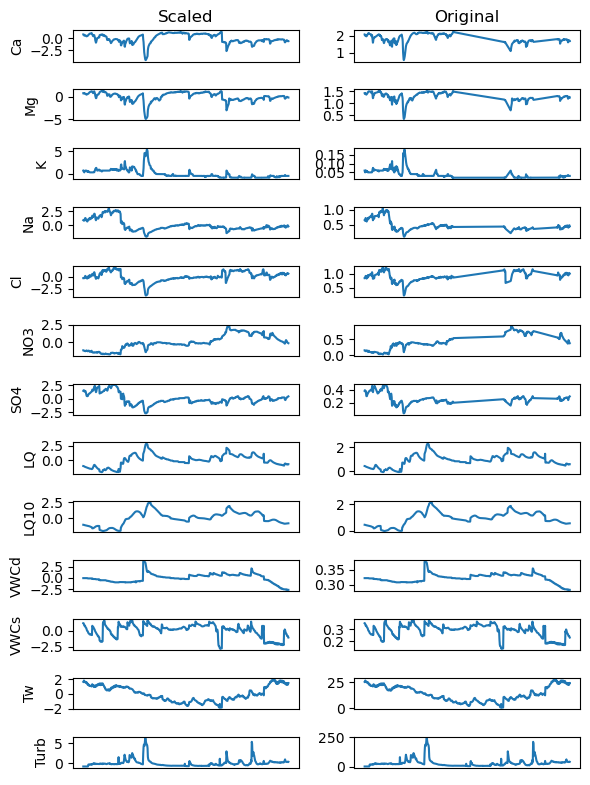

In [4]:
ct=1   
plt.figure(1,figsize=(6,12))
for i,a in enumerate(X_responses_scaled):
    plt.subplot(20,2,ct)
    plt.plot(a)
    
    plt.ylabel(labels_responses[i])
    plt.xticks([])
    if ct==1:
        plt.title('Scaled')
    
    ct+=1
    plt.subplot(20,2,ct)
    plt.plot(allvars_responses[i])
    plt.xticks([])
    if ct==2:
        plt.title('Original')
    ct+=1
    

for i,a in enumerate(X_drivers_scaled):
    plt.subplot(20,2,ct)
    plt.plot(a)
    plt.ylabel(labels_drivers[i])
    plt.xticks([])
    
    ct+=1
    plt.subplot(20,2,ct)
    plt.plot(allvars_drivers[i])
    plt.xticks([])
    ct+=1
    
plt.tight_layout()

plt.show()

X_responses_scaled = np.asarray(X_responses_scaled)
X_responses_scaled = np.reshape(X_responses_scaled,(np.shape(X_responses_scaled)[0],np.shape(X_responses_scaled)[1]))   

X_drivers_scaled = np.asarray(X_drivers_scaled)
X_drivers_scaled = np.reshape(X_drivers_scaled,(np.shape(X_drivers_scaled)[0],np.shape(X_drivers_scaled)[1]))   

X_all_scaled = np.asarray(X_all_scaled)
X_all_scaled = np.reshape(X_all_scaled,(np.shape(X_all_scaled)[0],np.shape(X_all_scaled)[1])) 

## Cluster data with Gaussian Mixture Model
- look at AIC and BIC across a range of cluster numbers
- covariance matrices shown for each cluster

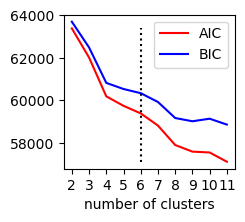

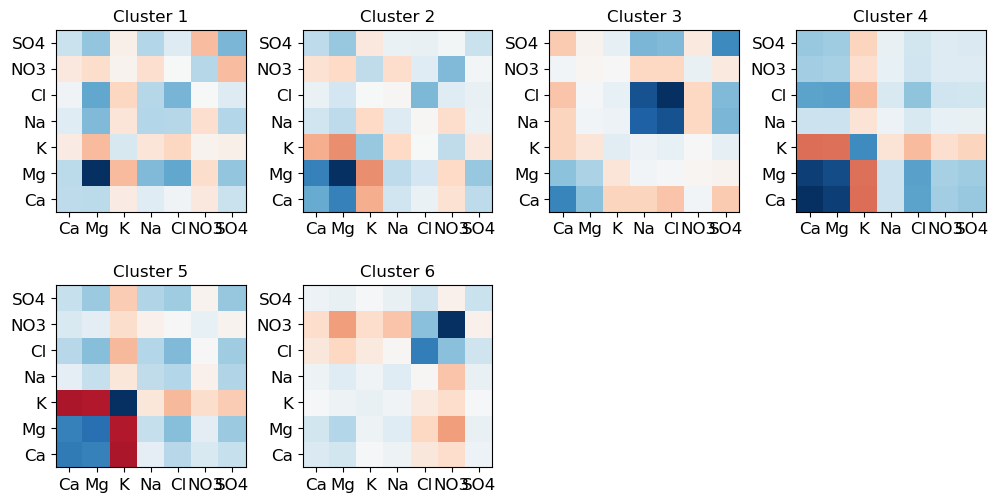

In [5]:
nc_range = range(2,12)
AIC,BIC = cf.GMMpick(X_responses_scaled,seed, nc_range)

fig = plt.figure(figsize=(2.2,2))
plt.plot(nc_range,AIC,'r')
plt.plot(nc_range,BIC,'b')

plt.vlines(nc, ymin=np.min(AIC),ymax=np.max(AIC),color='k',linestyle=':')
plt.legend(['AIC','BIC'])
plt.xlabel('number of clusters')
plt.xticks(nc_range)


# fit GMM to data
gmm_model, cluster_idx = cf.GMMfun(X_responses_scaled, nc, seed,1,labels_responses)

df['cluster_idx']=cluster_idx

## PCA of response system, IT-based driver selection
This can take a few minutes depending on the data size and IT parameters
- plots results for PCA weights (normalized), drivers, and "system predictability" colored by each cluster
- clusters are ranked based on explained variance (blue is lower total EV)

/Users/allison/Dropbox/PRI_UIUC/ResearchProjects/CINet-dominant-balance/CZ_ProcessesDriversPredictability/CZ_ProcessesDriversPredictability/cluster_funcs.py:283: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small[c]=(df_small[c]-df_small[c].min())/(df_small[c].max()-df_small[c].min())


cluster: 1 data length: 25
cluster: 2 data length: 175
cluster: 3 data length: 192
cluster: 4 data length: 117
cluster: 5 data length: 94
cluster: 6 data length: 14


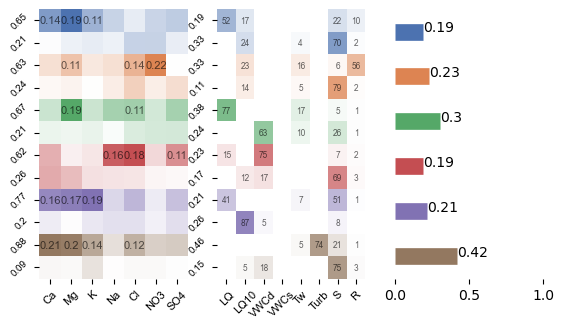

In [6]:

fig = plt.figure(figsize=(6.5,0.5+nc/2))

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

pca_model, rankings, balance_idx, pca1, pca2, weights, Xhats = cf.PCAfun(cluster_idx, nc, X_responses_scaled,ax1,labels_responses)

pca_ordered_weights = np.sum(pca_model[rankings],axis=1)

df['balance_idx']= balance_idx
df['pca1']=pca1
df['pca2']=pca2

#scale values to range from 0-1
df_minmax = df.copy()
for c in [colnames_drivers,colnames_responses]:
    df_minmax[c]=(df_minmax[c]-df_minmax[c].min())/(df_minmax[c].max()-df_minmax[c].min())

use_drivers, Itot_drivers, R_drivers, S_drivers, U1_drivers, U2_drivers = cf.infoFromDrivers(df_minmax, nc, ntars,colnames_drivers, labels_drivers, nbins, nTests, critval, ax2)

Ptotal = cf.Sys_info(nc, Itot_drivers, R_drivers, S_drivers, U1_drivers, U2_drivers, pca_ordered_weights,cm, ax3)



## Plotting (time-series, scatter plots, CV ratio relationships)

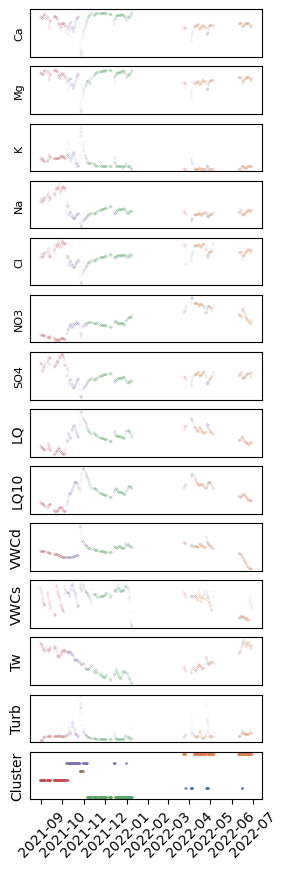

In [7]:
plt.figure(1,figsize=(3,11))

for i in range(1,nc+1): #loop through classes    
    df_small = df.loc[df['balance_idx']==i]
    ct=1
    for var in range(0,nfeatures):
        
        plt.figure(1)
        plt.subplot(15,1,ct)      
        plt.plot(pd.to_numeric(df_small[colnames_responses[var]]),'.',color=cm(i),markersize=.1,rasterized=True)
        plt.ylabel(labels_responses[var],fontsize=8)
        plt.xticks([])
        plt.yticks([])
        
        ct+=1
        
    for var in range(0,ntars):

        plt.subplot(15,1,ct)      
        plt.plot(pd.to_numeric(df_small[colnames_drivers[var]]),'.',color=cm(i),markersize=.1,rasterized=True)
        plt.ylabel(labels_drivers[var])
        
        plt.xticks([])
        plt.yticks([])

        ct+=1
        
    plt.subplot(15,1,ct)
    plt.plot(pd.to_numeric(df_small['cluster_idx']),'.',color=cm(i),markersize=1)
    plt.ylabel('Cluster')
    
    plt.yticks([])
    plt.xticks(rotation=45)
        
plt.subplots_adjust(hspace=.2,wspace=.2)


plt.show()

## scatter plots showing relationships, colored by clusters

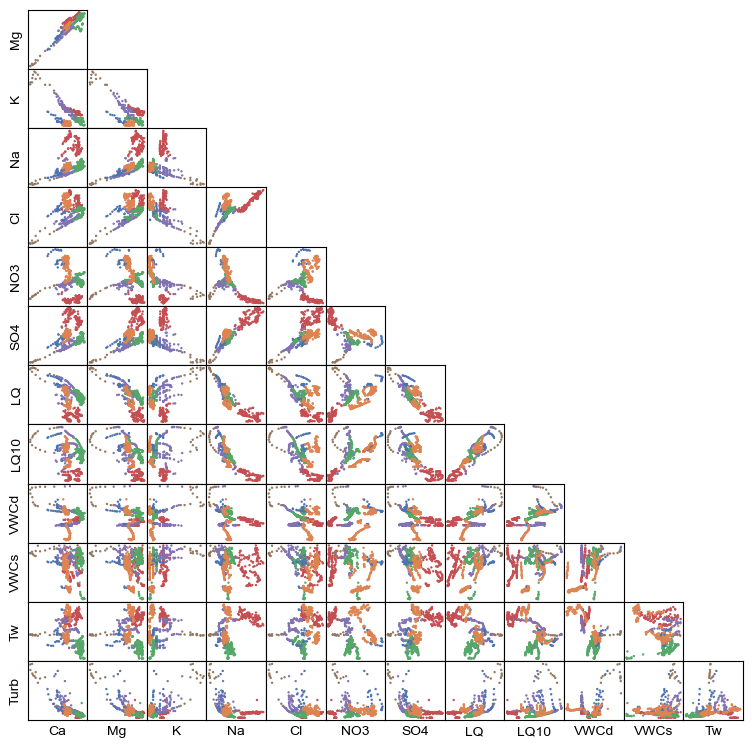

In [8]:

vals_responses = X_responses_scaled
vals_drivers = X_drivers_scaled

vals_responses = np.reshape(vals_responses,(np.shape(vals_responses)[0],np.shape(vals_responses)[1]))
vals_drivers = np.reshape(vals_drivers,(np.shape(vals_drivers)[0],np.shape(vals_drivers)[1]))

vals_all =np.concatenate((vals_responses, vals_drivers))

features = 1e3*np.vstack(vals_all).T
nvars_all = np.shape(features)[1]


ct=1
plt.figure(figsize=(10,10))
for i in range(nvars_all):
    for j in range(nvars_all):
        
        if j>=i:
            ct+=1
            continue
        else:
            plt.subplot(nvars_all,nvars_all,ct)
            plt.scatter(features[:, j], features[:,i], .5, balance_idx, cmap=cm,rasterized=True)
            if i== nvars_all-1:
                plt.xlabel(labels_all[j], fontsize=10,fontname='Arial')
            else:
                plt.xlabel('')
             
            if j==0:
                plt.ylabel(labels_all[i], fontsize=10,fontname='Arial')
            else:
                plt.ylabel('')
                
            plt.clim([-.5, cm.N-0.5])
            plt.xticks([])
            plt.yticks([])
            #plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(1, nc+1))
            plt.grid()
    
            plt.gca().tick_params(labelsize=10)
            plt.gca().tick_params(labelsize=10)
            ct+=1

plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

## scatter plots showing every relationship, colored by cluster 
-  this time plot the PC reconstructed versions of the response data

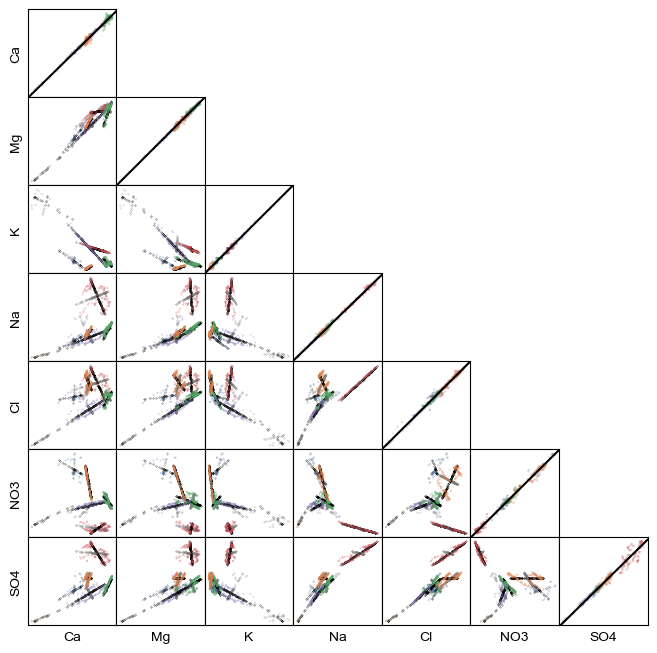

In [9]:
vals_responses1 = Xhats[0].T
vals_responses1 = np.reshape(vals_responses1,(np.shape(vals_responses1)[0],np.shape(vals_responses1)[1]))
feats1 = 1e3*np.vstack(vals_responses1).T

vals_responses2 = Xhats[1].T
vals_responses2 = np.reshape(vals_responses2,(np.shape(vals_responses2)[0],np.shape(vals_responses2)[1]))
feats2 = 1e3*np.vstack(vals_responses2).T

vals_responses_all = Xhats[2].T
vals_responses_all = np.reshape(vals_responses_all,(np.shape(vals_responses_all)[0],np.shape(vals_responses_all)[1]))
feats_all = 1e3*np.vstack(vals_responses_all).T


B = [1,2,3,4,5,6,7,8,9]
feat_inds = range(0,len(colnames_responses))

nvars = len(colnames_responses)

feats1 = np.array([row for i,row in enumerate(feats1) if balance_idx[i] in B])
feats2 = np.array([row for i,row in enumerate(feats2) if balance_idx[i] in B])
feats_all = np.array([row for i,row in enumerate(feats_all) if balance_idx[i] in B])

featsorig = np.array([row for i,row in enumerate(features) if balance_idx[i] in B])
bals = [row for i,row in enumerate(balance_idx) if balance_idx[i] in B]

ct=1
plt.figure(figsize=(8,8))
for i,fi in enumerate(feat_inds):
    for j,fj in enumerate(feat_inds):
        
             
        if j>i:
            ct+=1
            continue
        else:
            plt.subplot(nvars,nvars,ct)
            if j==i:
                
                xvals = feats_all[:, fj]/np.std(feats_all[:,fj])
                yvals = featsorig[:,fi]/np.std(featsorig[:,fi])
                xvals = np.where(yvals==0,np.nan,xvals)
                yvals = np.where(xvals==0,np.nan,yvals)
                plt.axline((-1,-1),(1,1),color='k')
                plt.scatter(xvals,yvals, .5, bals, cmap=cm, rasterized=True,alpha=0.2)
                #plot 1:1 dotted line
                
                
            elif fi < nfeatures and fj < nfeatures:  #response system - plot PC directions
                plt.scatter(feats2[:, fj], feats2[:,fi], .05, color='tab:gray', rasterized=True)
                
                plt.scatter(feats1[:, fj], feats1[:,fi], .05, color='k', rasterized=True)
                plt.scatter(feats_all[:, fj], feats_all[:,fi], .2, bals, cmap=cm, rasterized=True,alpha=0.3)
                
            else:
                xvals = feats_all[:,fj]
                yvals = feats_all[:,fi]
                xvals = np.where(yvals==0,np.nan,xvals)
                yvals = np.where(xvals==0,np.nan,yvals)   
                plt.scatter(xvals,yvals, .4, bals, cmap=cm, rasterized=True,alpha=0.3)
                
                
            if i== nvars-1:
                plt.xlabel(labels_all[fj], fontsize=10,fontname='Arial')
            else:
                plt.xlabel('')
             
            if j==0:
                plt.ylabel(labels_all[fi], fontsize=10,fontname='Arial')
            else:
                plt.ylabel('')
                
            plt.clim([-.5, cm.N-0.5])
            plt.xticks([])
            plt.yticks([])
            #plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(1, nc+1))
            plt.grid()
    
            plt.gca().tick_params(labelsize=10)
            plt.gca().tick_params(labelsize=10)
            ct+=1

plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

## Plot: b vs CV ratio overall and for each cluster

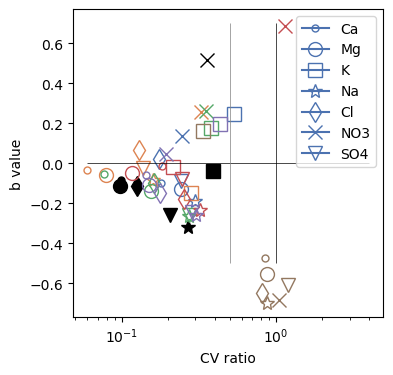

In [10]:
#%% compute coefficient of variation for each solute

from scipy import stats

CVratio = np.zeros((nc,len(colnames_responses)))
b = np.zeros((nc,len(colnames_responses)))
pvalue = np.zeros((nc,len(colnames_responses)))


CVratio_ratio = np.zeros((nc,len(colnames_responses)))
C_cv = np.zeros((nc,len(colnames_responses)))
Q_cv = np.zeros((nc,))


Q_cv_all = df['Discharge'].std()/df['Discharge'].mean()
CVratio_alltime = np.zeros((len(colnames_responses),))

b_alltime = np.zeros((len(colnames_responses),))
p_alltime = np.zeros((len(colnames_responses),))

mstyle = ['.','o','s','*','d','x','v']

plt.figure(figsize=(4,4))

for ind_c,c in enumerate(colnames_responses):
    CVratio_alltime[ind_c]=df[c].std()/df[c].mean()/Q_cv_all
    logC = np.asarray(np.log10(df[c]))
    logQ = np.asarray(np.log10(df['Discharge']))
    result = stats.linregress(logQ,logC)
    b_alltime[ind_c]  = result.slope
    p_alltime[ind_c]  = result.rvalue**2
    
    plt.semilogx(CVratio_alltime[ind_c],b_alltime[ind_c],marker=mstyle[ind_c],color='k',markersize=10)


hall=[]
for ind_i,i in enumerate(range(1,nc+1)): #loop through classes    
    df_small = df.loc[df['balance_idx']==i]
    
    Q_cv[ind_i] = df_small['Discharge'].std()/df_small['Discharge'].mean()
    
    for ind_c,c in enumerate(colnames_responses):
        C_cv[ind_i,ind_c] = df_small[c].std()/df_small[c].mean()
        CVratio[ind_i, ind_c] = C_cv[ind_i,ind_c] /Q_cv[ind_i]
        CVratio_ratio[ind_i,ind_c]=(CVratio[ind_i, ind_c] - CVratio_alltime[ind_c])/CVratio_alltime[ind_c]
        
        #also look at power-law regresssion slopes
        logC = np.asarray(np.log10(df_small[c]))
        logQ = np.asarray(np.log10(df_small['Discharge']))
        result = stats.linregress(logQ,logC)
        b[ind_i,ind_c]  = result.slope
        pvalue[ind_i,ind_c]  = result.rvalue**2
        
        hh, = plt.semilogx(CVratio[ind_i,ind_c],b[ind_i,ind_c],marker=mstyle[ind_c],color=cm(i),markerfacecolor='None',markersize=10)
        if i==1:
            hall.append(hh)
        
        
plt.hlines(0,.06,4,color='k',linewidth=0.5)
plt.vlines(1,-.5,.7,color='k',linewidth=0.5)
plt.vlines(0.5,-.5,.7,color='gray',linewidth=0.5)
plt.xlabel('CV ratio')
plt.ylabel('b value')
plt.legend(hall,labels_responses)

plt.show()


## Plot: Cluster frequencies with flow ranges

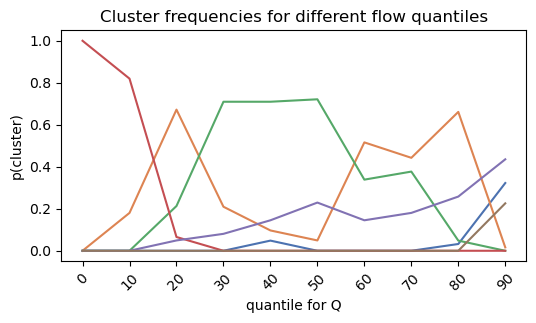

In [11]:
flow_ranges = np.asarray(df['Discharge'].quantile([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]))


flows = np.zeros((nc,10))


for c_ind,c in enumerate(colnames_responses):

    for i in range(1,nc+1): #loop through classes
        for m_ind,m in enumerate(flow_ranges[:-1]): #loop trhough flow quantiles
            df_small = df.loc[(df['balance_idx']==i) & (df['Discharge']>m) & (df['Discharge']<=flow_ranges[m_ind+1]) ]

            flows[i-1,m_ind]=len(df_small)

p_flows =flows/np.sum(flows)
p_m = np.sum(p_flows,axis=0)
conditional_prob = p_flows/p_m #prob of a cluster, given a time of day
plt.figure(figsize=(6,3))
for i in range(0,nc): #loop through classes
    plt.plot(conditional_prob[i,:],color=cm(i+1))
    
    
plt.xticks(range(0,len(flow_ranges[:-1])),range(0,100,10),rotation=45)
plt.title('Cluster frequencies for different flow quantiles')
plt.xlabel('quantile for Q')
plt.ylabel('p(cluster)')

plt.show()